In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import GPy
from PEP_reg import PEP
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import time
from utils import calculate_metric
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import GPy
from sklearn.decomposition import PCA

In [3]:
# Configuration
DATA_FOLDER = "../data"
TRAIN_FEATURES = DATA_FOLDER + '/train_features2.xlsx'
TRAIN_LABELS = DATA_FOLDER + "/train_labels2.xlsx"
TEST_FEATURES = DATA_FOLDER + "/test_features2.xlsx"
TEST_LABELS = DATA_FOLDER + "/test_labels2.xlsx"
OUTPUT_PATH = '../output/PEP'

In [4]:
# Set random seed
np.random.seed(42)

In [30]:
# Load data
train_features = pd.read_excel(TRAIN_FEATURES)
train_labels = pd.read_excel(TRAIN_LABELS)
test_features = pd.read_excel(TEST_FEATURES)
test_labels = pd.read_excel(TEST_LABELS)

print("Training data shape:", train_features.shape)
print("Test data shape:", test_features.shape)

Training data shape: (1293, 317)
Test data shape: (432, 317)


In [31]:
input_dim = 100
pca = PCA(n_components=input_dim)
train_features = pca.fit_transform(train_features)

In [32]:
test_features = pca.transform(test_features)

In [14]:
# # Get feature lists
# feature_list = train_features.columns
# category_features = train_features.select_dtypes(include=['bool']).columns
# non_category_features = [i for i in feature_list if i not in category_features]

# print("Number of categorical features:", len(category_features))
# print("Number of numerical features:", len(non_category_features))

In [33]:
# Prepare data
# scaler = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), non_category_features)
#     ],
#     remainder='passthrough'  # Leave categorical features untouched
# )
scaler = StandardScaler()

# Scale the features
X_train_scaled = scaler.fit_transform(train_features)
X_test_scaled = scaler.transform(test_features)

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(train_labels.values)
y_test = y_scaler.transform(test_labels.values)

In [36]:
def select_inducing_points_variance(X, num_inducing, seed=None):
    """
    Select inducing points based on variance in each dimension
    Efficient for high-dimensional data
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Calculate variance contribution of each point
    mean = X.mean(axis=0)
    point_variances = np.sum((X - mean)**2, axis=1)
    
    # Select points with probability proportional to their variance contribution
    probs = point_variances / point_variances.sum()
    indices = np.random.choice(
        X.shape[0], 
        size=num_inducing, 
        replace=False, 
        p=probs
    )
    
    return X[indices]

In [40]:
def select_inducing_points_clustering(X, num_inducing, n_components=None, seed=None):
    """
    Select inducing points using clustering after dimensionality reduction
    Efficient for high-dimensional data
    """
    from sklearn.cluster import MiniBatchKMeans
    from sklearn.decomposition import PCA
    
    if seed is not None:
        np.random.seed(seed)
    
    # First reduce dimensionality if needed
    if n_components is not None and n_components < X.shape[1]:
        pca = PCA(n_components=n_components)
        X_reduced = pca.fit_transform(X)
    else:
        X_reduced = X
    
    # Use MiniBatchKMeans for efficiency
    kmeans = MiniBatchKMeans(
        n_clusters=num_inducing,
        batch_size=1000,
        random_state=seed
    )
    
    # Fit clustering
    cluster_labels = kmeans.fit_predict(X_reduced)
    
    # Select points closest to cluster centers
    selected_indices = []
    for i in range(num_inducing):
        cluster_points = X_reduced[cluster_labels == i]
        if len(cluster_points) > 0:
            # Find point closest to cluster center
            center = kmeans.cluster_centers_[i]
            distances = np.sum((cluster_points - center)**2, axis=1)
            cluster_idx = np.where(cluster_labels == i)[0][np.argmin(distances)]
            selected_indices.append(cluster_idx)
    
    return X[selected_indices]

In [39]:
# Model parameters
alpha = 0.5  # PEP hyperparameter
# input_dim = X_train_scaled.shape[1]  # Number of features
num_inducing = 200 

In [40]:
# Select inducing points using k-means
kmeans = KMeans(n_clusters=num_inducing, random_state=0)
kmeans.fit(X_train_scaled)
inducing_points = kmeans.cluster_centers_
# inducing_points = select_inducing_points_variance(
#     X=X_train_scaled,
#     num_inducing=min(300, X_train_scaled.shape[0] // 4),
#     seed=42
# )

# inducing_points = select_inducing_points_clustering(
#     X=X_train_scaled,
#     num_inducing=min(300, X_train_scaled.shape[0] // 4),
#     n_components=100
# )

# Initialize kernel with ARD
k = GPy.kern.RBF(input_dim=input_dim, ARD=True)

# Create sparse GP model with PEP inference
model = GPy.models.SparseGPRegression(X_train_scaled, y_train, kernel=k, Z=inducing_points)
# model.name = 'POWER-EP'
model.inference_method = GPy.inference.latent_function_inference.PEP(alpha=alpha)

# Set initial noise variance and unfix parameters
# model.Gaussian_noise.variance = 1e-3
# model.unfix()

print("Initial model parameters:")
print(model)

Initial model parameters:

Name : sparse_gp
Objective : 2384.834399861245
Number of Parameters : 20102
Number of Optimization Parameters : 20102
Updates : True
Parameters:
  sparse_gp.               |       value  |  constraints  |  priors
  inducing_inputs          |  (200, 100)  |               |        
  rbf.variance             |         1.0  |      +ve      |        
  rbf.lengthscale          |      (100,)  |      +ve      |        
  Gaussian_noise.variance  |         1.0  |      +ve      |        


In [41]:
# Train the model
start_time = time.time()

# Optimize with multiple restarts to avoid local minima
model.optimize_restarts(num_restarts=5, optimizer='bfgs', 
                       messages=True, max_iters=1000)

elapsed_time = time.time() - start_time
print(f"\nTraining time: {elapsed_time:.3f} seconds")

print("\nOptimized model parameters:")
print(model)

 /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in divide
 /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in divide
 /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Library/Frameworks/Python.framework/Versio

Optimization restart 1/5, f = 1653.1243625683505


Optimization restart 2/5, f = 1834.6875292935258


Optimization restart 3/5, f = 1834.687532641314


Optimization restart 4/5, f = 1834.6875265550282


Optimization restart 5/5, f = 1834.687545923692

Training time: 1636.803 seconds

Optimized model parameters:

Name : sparse_gp
Objective : 1653.1243625683505
Number of Parameters : 20102
Number of Optimization Parameters : 20102
Updates : True
Parameters:
  sparse_gp.               |               value  |  constraints  |  priors
  inducing_inputs          |          (200, 100)  |               |        
  rbf.variance             |  404.24956720763777  |      +ve      |        
  rbf.lengthscale          |              (100,)  |      +ve      |        
  Gaussian_noise.variance  |  0.6108333023425697  |      +ve      |        


In [42]:
def predict(model, X_new, X_scaler, y_scaler):
    X_scaled = X_scaler.transform(X_new)
    mean, var = model.predict(X_scaled)
    mean = y_scaler.inverse_transform(mean)
    var = var * (y_scaler.scale_ ** 2)
    return mean, var

In [43]:
# Make predictions
mean_train, var_train = predict(model, train_features, scaler, y_scaler)
mean_test, var_test = predict(model, test_features, scaler, y_scaler)

# Calculate metrics for training data
train_mae, train_mape, train_rmse, train_rsqr = calculate_metric(
    mean_train, train_labels['rr1_30'].values
)

# Calculate metrics for test data
test_mae, test_mape, test_rmse, test_rsqr = calculate_metric(
    mean_test, test_labels['rr1_30'].values
)

print("Training Metrics:")
print(f"Mean Absolute Error: {train_mae:.4f}")
print(f"Mean Absolute Percentage Error: {train_mape:.4f}")
print(f"Root Mean Square Error: {train_rmse:.4f}")
print(f"R-squared: {train_rsqr:.4f}")

print("\nTest Metrics:")
print(f"Mean Absolute Error: {test_mae:.4f}")
print(f"Mean Absolute Percentage Error: {test_mape:.4f}")
print(f"Root Mean Square Error: {test_rmse:.4f}")
print(f"R-squared: {test_rsqr:.4f}")

Training Metrics:
Mean Absolute Error: 0.3169
Mean Absolute Percentage Error: 4636.1783
Root Mean Square Error: 0.2547
R-squared: 0.4023

Test Metrics:
Mean Absolute Error: 0.3235
Mean Absolute Percentage Error: 387.2627
Root Mean Square Error: 0.2865
R-squared: 0.2833


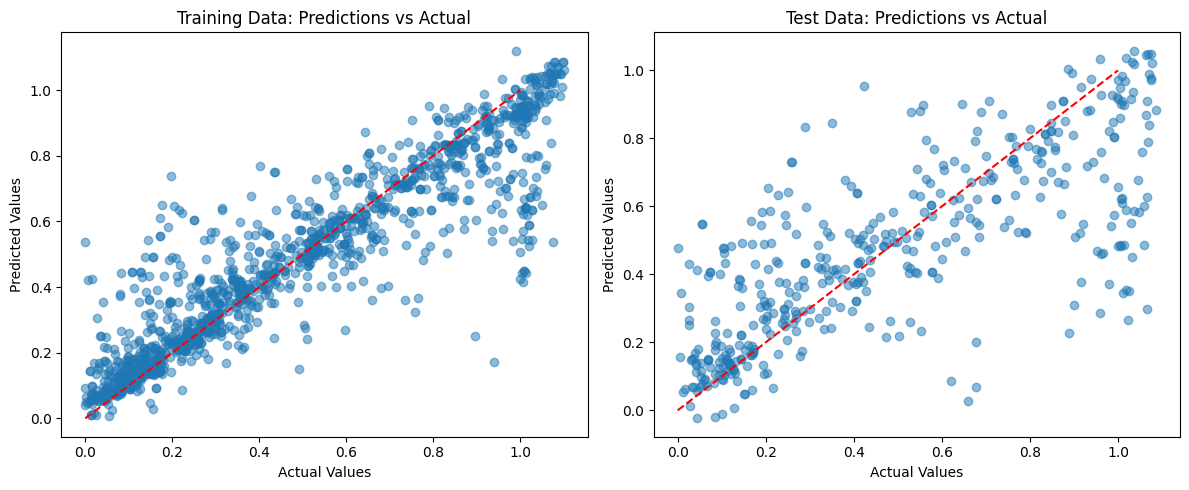

In [55]:
# Visualize predictions vs actual values
plt.figure(figsize=(12, 5))

# Training data
plt.subplot(1, 2, 1)
plt.scatter(train_labels['rr1_30'].values, mean_train, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Training Data: Predictions vs Actual')

# Test data
plt.subplot(1, 2, 2)
plt.scatter(test_labels['rr1_30'].values, mean_test, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Test Data: Predictions vs Actual')

plt.tight_layout()
plt.show()

In [56]:
np.sqrt(var_train.ravel()).shape

(1293,)

In [57]:
train_labels['rr1_30'].shape

(1293,)

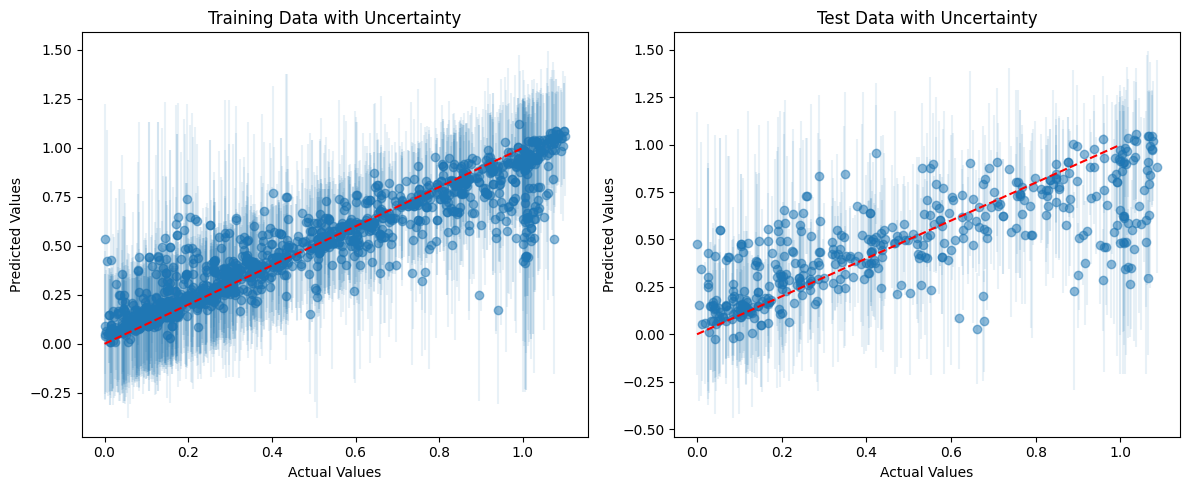

In [58]:
# Plot uncertainty estimates
plt.figure(figsize=(12, 5))

# Training data uncertainty
plt.subplot(1, 2, 1)
plt.errorbar(train_labels['rr1_30'].values, mean_train.ravel(), 
             yerr=2*np.sqrt(var_train.ravel()), fmt='none', alpha=0.1)
plt.scatter(train_labels['rr1_30'].values, mean_train, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Training Data with Uncertainty')

# Test data uncertainty
plt.subplot(1, 2, 2)
plt.errorbar(test_labels['rr1_30'].values, mean_test.ravel(), 
             yerr=2*np.sqrt(var_test.ravel()), fmt='none', alpha=0.1)
plt.scatter(test_labels['rr1_30'].values, mean_test, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Test Data with Uncertainty')

plt.tight_layout()
plt.show()